### Cluster config and example .sbatch script

Slurm .sbatch file

```bash
#!/bin/bash

#SBATCH --time=24:00:00               # Set the job time limit to 24 hours
#SBATCH --partition=gpu               # Specify the GPU partition
#SBATCH --gres=gpu:1                  # Request 1 GPU
#SBATCH --constraint=v100             # Constrain job to run on V100 GPUs
#SBATCH --nodes=1                     # Request 1 node
#SBATCH --ntasks-per-node=2           # Run 2 tasks per node
#SBATCH --mem-per-cpu=24000           # Request 24GB of memory per CPU
#SBATCH --job-name=GENN               # Set the job name to GENN
#SBATCH --account=pi-clayc            # Specify the account to charge
#SBATCH --mail-type=ALL               # Send email notifications for all job events
#SBATCH --mail-user=ashmore@rcc.uchicago.edu  # Email address for notifications
#SBATCH --output=slurm-%j.out         # Set the initial output file name (%j is the job ID)

# Parse named arguments
# Usage: sbatch script_name.sbatch ZN=1 nx=2 start=3 stop=4 step_size=5
for ARGUMENT in "$@"
do
    KEY=$(echo $ARGUMENT | cut -f1 -d=)
    VALUE=$(echo $ARGUMENT | cut -f2 -d=)   

    case "$KEY" in
            ZN)              ZN=${VALUE} ;;
            nx)              nx=${VALUE} ;;
            start)           start=${VALUE} ;;
            stop)            end=${VALUE} ;;
            step_size)       step_size=${VALUE} ;;
            *)   
    esac    
done

# Define the custom output file name including job ID and parameters
OUTPUT_FILE="slurm-${SLURM_JOB_ID}-ZN=${ZN}_nx=${nx}_start=${start}_stop=${end}_step=${step_size}.out"

# Rename the output file if we're in a Slurm job
if [ -n "$SLURM_JOB_ID" ]; then
    mv slurm-$SLURM_JOB_ID.out $OUTPUT_FILE
fi

# Set ulimit for locked memory to unlimited
ulimit -l unlimited

# Set up pyenv in read-only mode
export PYENV_ROOT="/project/clayc/.pyenv"
export PATH="$PYENV_ROOT/versions/3.12.3/bin:$PATH"

# Print Python and pyenv versions to verify
echo "pyenv version: $($PYENV_ROOT/bin/pyenv --version)"
echo "Python version: $(python --version)"
echo "Python path: $(which python)"

# Print Python and pyenv versions to verify the setup
module load openmpi/5.0.2

# Set environment variables for CUDA and JAX
export MPI4JAX_USE_CUDA_MPI=0
export CUDA_VISIBLE_DEVICES="$(echo $CUDA_VISIBLE_DEVICES | cut -d ',' -f $(($SLURM_LOCALID+1)))"
export XLA_PYTHON_CLIENT_PREALLOCATE=false

# Print GPU information
nvidia-smi
# mpirun -n 1 python -m netket.tools.check_mpi

# Run the Python script with the parsed arguments
python 2d_ZN_LxL.py --ZN $ZN --nx $nx --start $start --stop $end --step_size $step_size

# Commented out MPI run command (if needed in the future)
# mpirun -n 1 python 2d_ZN_LxL.py --ZN $ZN --nx $nx --start $start --stop $end --step_size $step_size
```

When running on cluster, we can pass various parameters as arguments to the slurm script.

In [318]:
import os
import sys
import argparse
from argparse import Namespace

def parse_arguments():
    """
    Parse command line arguments for the 2D ZN LxL training.

    Returns:
        argparse.Namespace: Parsed command line arguments.
    """
    parser = argparse.ArgumentParser(description='Run 2D ZN LxL training')
    parser.add_argument('--ZN', type=int, required=True, help='ZN parameter')
    parser.add_argument('--nx', type=int, required=True, help='nx parameter')
    parser.add_argument('--start', type=float, required=True, help='g start value')
    parser.add_argument('--stop', type=float, required=True, help='g end value')
    parser.add_argument('--step_size', type=float, required=True, help='g step size')
    return parser.parse_args()

# Check if running in Jupyter
if 'ipykernel' in sys.modules:
    # If in Jupyter, set default values or the values you want to test
    args = Namespace(ZN=2, nx=2, start=0.6, stop=0.5, step_size=0.1)
else:
    # If running as a script, use command line arguments
    args = parse_arguments()

If running on Google Colab, mount Google Drive folder here

In [319]:
# from google.colab import drive
# drive.mount('/content/drive/')

### Collect inputs from slurm script

In [320]:
# fix "N" in Z_N
ZN = args.ZN

# size of lattice
nx = args.nx
ny = nx

# Get coupling range and step size from shell
start = args.start
stop = args.stop
step_size = args.step_size

import numpy as np

# Calculate number of steps and create coupling range
steps = abs(round((stop - start)/step_size)) + 1
g_range = np.linspace(start, stop, steps)

# Print simulation parameters
print()
print("*********************************************")
print("Lattice size:", nx, "x", ny)
print("N =", ZN)
print("Running on couplings from","{:.4f}".format(start),"to","{:.4f}".format(stop),"in steps of","{:.4f}".format(step_size))
print("g =", g_range)
print("*********************************************", end="\n\n")


*********************************************
Lattice size: 2 x 2
N = 2
Running on couplings from 0.6000 to 0.5000 in steps of 0.1000
g = [0.6 0.5]
*********************************************



### Hyperparameters and training/observables/saving choices

Define model/sampler/training hyperparameters. Also whether to start from previous vstate, whether to train or just load a vstate for each coupling, which observables to compute, whether to save the vstates, and what data to save to .csv

In [321]:
# PARAMETERS FOR MODEL

# how many LCB layers?
depth = int(np.ceil(np.log2(nx * ny)))
# width of LCB layers?
width = 4
# shifts of LCB layers?
shift = 2
# number of dense layers at end?
dense_features = ()*1

####

# PARAMETERS FOR TRAINING

# initial learning rate?
lr = 0.01
# constant diagonal shift?
diag_shift = 1e-4
# max training iterations?
iterations = 20
# samples per iteration?
n_samples = 4 * 1024

# WHERE TO START TRAINING FROM

# load previous vstate at start of training?
load_previous_vstate = True
# previous vstate dir
previous_vstate_dir = 'vstates'
# previous vstate name - no .mpack at end
#previous_vstate_name_str = "ZN=3_nx=2_ny=2_g=1.1_LConvBilin_layers=(4, 4)_shifts=(2, 2)_dense_features=()_n_samples=4096"

####

# TRAIN AND/OR JUST COMPUTE OBSERVABLES?

# do we train the model?
train_model = True
# do we load a previous model for each coupling?
# either to train it further, or just use it to compute observabales
load_trained_model = False
# trained vstate dir
trained_vstate_dir = 'vstates'
# trained vstate name - give list of strings that will be converted to the variable when saving
trained_vstate_name = ['ZN','nx','ny','g','LConvBilin_layers','shifts','dense_features','n_samples']
# extra comment to add to end of vstate name
trained_vstate_comment = ''

####

# WHICH OBSERVABLES TO COMPUTE

# do we compute these observables? if we compute expectations, how many samples to use?
# H
compute_H = False
n_samples_H = 8*4096
# H, H_E, H_B
compute_H_deriv = True
n_samples_H_deriv = 8*4096
# Creutz ratio
compute_creutz = False
n_samples_creutz = 8*4096
# `t Hooft string
compute_thooft = True
n_samples_thooft = 8*4096
thooft_x_length = int(nx / 2)
thooft_y_length = 0

####

# WHAT DO WE SAVE?

# save trained vstate?
save_vstate = True
# save vstate dir
save_vstate_dir = 'vstates'
# save vstate name - give list of strings that will be converted to the variable when saving
save_vstate_name = ['ZN','nx','ny','g','LConvBilin_layers','shifts','dense_features','n_samples']
# extra comment to add to end of vstate name
save_vstate_comment = ''

# save results?
save_results = True
# save results dir
save_results_dir = 'data'
# save results dir - give list of strings that will be converted to the variable when saving
save_results_name = 'test_data'
# save results dir - give list of strings that will be converted to the variable when saving
save_results_vars = ['ZN', 'nx', 'ny', 'g', 'n_samples', 'iterations', 'H_mean', 'H_error', 'H_var', 'H_tau', 'H_E_mean', 'H_E_error', 'H_B_mean', 'H_B_error', 'n_samples_H_deriv', 'thooft_mean', 'thooft_error', 'thooft_tau', 'n_samples_thooft']

### Load packages and set environment flags before loading netket

Import MPI and check how many ranks / GPUs

In [322]:
from mpi4py import MPI

# Get the rank of the current process
rank = MPI.COMM_WORLD.Get_rank()

# Print the number of GPUs (assuming one GPU per MPI process)
print("Number of gpus:", rank)

Number of gpus: 0


Set various environment flags for NetKet, e.g. whether using CPU or GPU

In [323]:
# Specify CPU or GPU for JAX operations
if 'ipykernel' in sys.modules:
    # If in Jupyter, use CPU
    os.environ["JAX_PLATFORM_NAME"] = "cpu"
else:
    # If not in Jupyter (e.g., on a cluster), use GPU
    os.environ["JAX_PLATFORM_NAME"] = "gpu"

# Turn off float64 precision (currently commented out)
# os.environ["NETKET_ENABLE_X64"] = "0"

# Enable experimental NetKet features
os.environ["NETKET_EXPERIMENTAL"] = "1"

# Use more accurate calculation of tau in NetKet
os.environ["NETKET_EXPERIMENTAL_FFT_AUTOCORRELATION"] = "1"

# Prevent JAX from preallocating GPU memory (commented out, typically used in Jupyter)
# %env XLA_PYTHON_CLIENT_PREALLOCATE=false

Import NetKet and check the version. Also load various packages that we need later.

In [324]:
import jax

# Check NetKet installation and print version
import netket as nk
print(f"NetKet version: {nk.__version__}")

# Print available JAX devices for the current process
print(f"{rank} -> {jax.devices()}")
print(jax.devices())

# Import necessary libraries
import netket.experimental as nkx
import functools
from functools import partial
import flax.linen as nn
import numpy as np
import jax.numpy as jnp
import flax
import optax
import csv

NetKet version: 3.12.1.dev42+g9d32802a
0 -> [CpuDevice(id=0)]
[CpuDevice(id=0)]


### Generate the lattice, etc.

Generate the 2d lattice of sites and define the Hilbert spaces for the links

Total number of symmetries of lattice: 4


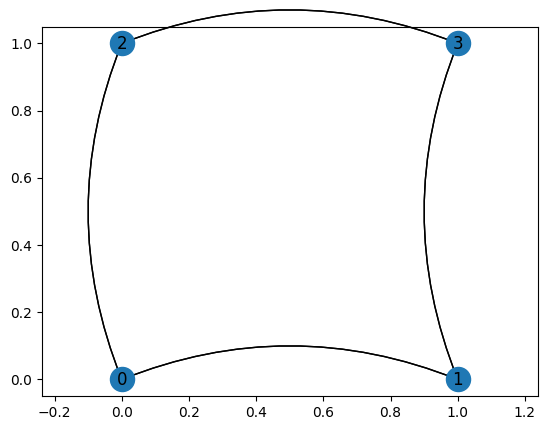

In [325]:
from netket.graph import Lattice

# Define basis vectors for the lattice
basis = np.array([
    [0, 1],
    [1, 0],
])

# Define custom edges for the lattice
custom_edges = [
    (0, 0, [1, 0], 0),
    (0, 0, [0, 1], 1),
]

# Create a Lattice object with periodic boundary conditions
graph = Lattice(basis_vectors=basis, pbc=True, extent=[ny, nx],
                custom_edges=custom_edges)

# Visualize the graph if running in Jupyter
if 'ipykernel' in sys.modules:
    graph.draw()

# Print the total number of symmetries in the lattice
print("Total number of symmetries of lattice:", len(graph.automorphisms()))

# Calculate the number of sites in the graph
N_sites = graph.n_nodes

# Calculate the number of links in the graph
N_links = 2 * graph.n_nodes

# Define a Hilbert space for the links
# Fock(i) gives states (0,1,2,..,i) so we want Fock(N-1)
hi = nk.hilbert.Fock(n_max=ZN-1)**(N_links)

Generate the Hilbert space id's of the links for plaquettes and gauge operator

In [326]:
# Define ranges for all link and site IDs
link_ids = range(0, N_links)
site_ids = range(0, N_sites)

# Define ranges for x and y link IDs
# x links are first N_sites elements of Hilbert space, y links are next N_sites elements of Hilbert space
x_link_ids = range(0, N_sites)
y_link_ids = range(N_sites, 2 * N_sites)

# Helper data for computing Hilbert space IDs of plaquettes and gauge operator links

# x-link at site at position [i,j]
x_i_j = graph.id_from_position(graph.positions)
# y-link at site at position [i+1,j]
y_ip1_j = graph.id_from_position(graph.positions + [1.,0.]) + N_sites
# x-link at site at position [i,j+1]
x_i_jp1 = graph.id_from_position(graph.positions + [0.,1.])
# y-link at site at position [i,j]
y_i_j = graph.id_from_position(graph.positions) + N_sites
# x-link at site at position [i-1,j]
x_im1_j = graph.id_from_position(graph.positions + [-1.,0.])
# y-link at site at position [i,j-1]
y_i_jm1 = graph.id_from_position(graph.positions + [0.,-1.]) + N_sites

# Create list of plaquette IDs
# Each tuple contains the Hilbert space ID for the links in a plaquette
# Links are ordered so that at site i, you get the link to the right first,
# then the rest going anticlockwise
plaq_ids = [(i,j,k,l) for i,j,k,l in zip(x_i_j, y_ip1_j, x_i_jp1, y_i_j)]

# Create list of gauge IDs
# Each tuple contains the Hilbert space ID for the links associated to each site
# (for gauge operator), first to the right, then above and so on anticlockwise
gauge_ids = [(i,j,k,l) for i,j,k,l in zip(x_i_j, y_i_j, x_im1_j, y_i_jm1)]

Now generate a random states to check everything is working

In [327]:
# Generate and print a random state from the Hilbert space
print(hi.random_state(key=jax.random.PRNGKey(0)))

[0. 0. 0. 1. 1. 1. 1. 0.]


### Define Hamiltonian for $\mathbb{Z}_N$ system

Clock and shift operators match with $Q$ and $P$ from 2008.00882.

In [328]:
# Import custom ZN modules
import ZN_operators
import ZN_functions
import ZN_nn_layers
import ZN_thooft
import ZN_wilson

# Set lattice size in the imported ZN_functions module
ZN_functions.nx = nx
ZN_functions.ny = ny

Code to reload operators if their definitions have changed - useful when prototyping in a notebook!

In [329]:
# Check if running in a Jupyter environment
if 'ipykernel' in sys.modules:
    # Import the reload function from importlib
    from importlib import reload
    
    # Reload custom modules to ensure the latest versions are used
    ZN_operators = reload(ZN_operators)
    ZN_nn_layers = reload(ZN_nn_layers)
    ZN_functions = reload(ZN_functions)
    ZN_thooft = reload(ZN_thooft)
    ZN_wilson = reload(ZN_wilson)

Hamiltonian for $\mathbb{Z}_N$ gauge theory from 2008.00882. Includes constant shift terms which move energy by $+L^2 (g^2 + 1/g^2)$, where $L^2$ is number of lattice sites. Here we also specify the coupling $g$.

In [330]:
# Define the full Hamiltonian as a function of coupling g
H_g = partial(ZN_operators.Hamiltonian_ZN, hilbert=hi, plaq_ids=plaq_ids, link_ids=link_ids)

# Define the electric part of the Hamiltonian as a function of coupling g
H_E_g = partial(ZN_operators.Hamiltonian_ZN_electric, hilbert=hi, plaq_ids=plaq_ids, link_ids=link_ids)

# Define the magnetic part of the Hamiltonian as a function of coupling g
H_B_g = partial(ZN_operators.Hamiltonian_ZN_magnetic, hilbert=hi, plaq_ids=plaq_ids, link_ids=link_ids)

$\mathbb{Z}_N$ gauge operator. Define $\Theta_x = P_{x,\mu} P_{x,\nu} P^\dagger_{x-\mu,\mu} P^\dagger_{x-\nu,\nu}$. The gauge invariance condition is then $\Theta_x |\Psi\rangle = \pm |\Psi\rangle$ with the same choice of sign for all $x$. We can then impose this as a positive definite condition as $(\Theta-1)(\Theta^\dagger - 1) = $ on gauge invariant states. We can use this as a check that our neural network is giving a gauge-invariant output.

In [331]:
# Define the gauge operator
# This should give +-(N_sites) on a gauge invariant state
gauge = ZN_operators.gauge_ZN(hi, gauge_ids)

# Define the gauge zero operator
# This should give 0 on a gauge invariant state
gauge_zero = ZN_operators.gauge_zero_ZN(hi, gauge_ids)

### Define model, sampler, vstate

Define model/sampler/vstate parameters that we likely won't change from run to run

In [332]:
# Network architecture parameters
LConvBilin_layers = (width,) * depth
shifts = (shift,) * depth

# Initial standard deviation for weights (not used if LSUV is used)
stddev = 0.001

# MCMC parameters
n_chains_per_rank = 128  # Number of MCMC chains per rank
n_sweeps = N_links  # Number of MCMC sweeps
n_discard_per_chain = 10  # Number of samples to discard per chain

# Training parameters
lr_schedule = optax.linear_schedule(init_value=lr, end_value=0, transition_steps=iterations)
lr_schedule = optax.exponential_decay(init_value=lr, transition_steps=100, decay_rate=0.333, staircase=True)
clip = optax.clip_by_global_norm(max_norm=0.1*1/lr)

diag_shift_decay = 1.  # Not used
early_stopping = N_sites * 0.000125  # Early stopping threshold based on energy sample variance
reset_vstate = False  # Whether to reset the variational state when changing coupling
is_holomorphic = False  # Assume variational state is holomorphic as a function of weights
precision = 'double'  # Precision for network calculations ('double' or 'single')
chunk_size = 4096  # Chunk size for processing

# Early stopping parameters
patience = 100  # Number of iterations to wait before early stopping
smoothing_window = 10  # Window size for smoothing the variance for early stopping

If we are loading a previous vstate, we can change the various parameters to match (in case we didn't set them correctly above!)

In [335]:
# this loads the previous vstate by using the last value of the coupling 
if stop > start:
    previous_vstate_name_str = 'ZN='+str(ZN)+'_nx='+str(nx)+'_ny='+str(ny)+'_g='+f"{start-step_size:.4f}"+'_LConvBilin_layers='+str(LConvBilin_layers)+'_shifts='+str(shifts)+'_dense_features='+str(dense_features)+'_n_samples='+str(n_samples)
elif start > stop:
    previous_vstate_name_str = 'ZN='+str(ZN)+'_nx='+str(nx)+'_ny='+str(ny)+'_g='+f"{start+step_size:.4f}"+'_LConvBilin_layers='+str(LConvBilin_layers)+'_shifts='+str(shifts)+'_dense_features='+str(dense_features)+'_n_samples='+str(n_samples)

In [336]:
if load_previous_vstate:
    # Load dictionary of previous model, sampler and vstate parameters
    load_params = ZN_functions.load_model_params(previous_vstate_dir, previous_vstate_name_str)

    # Verify that the Hilbert space matches
    assert str(hi) == load_params['sampler']['hilbert'], "Hilbert spaces do not match!"

    # Verify that Z_N matches
    assert str(ZN) == load_params['model']['N'], "Z_N does not match!"

    # Load model parameters
    LConvBilin_layers = eval(load_params['model']['N_out'])
    shifts = eval(load_params['model']['shifts'])
    dense_features = eval(load_params['model']['features'])
    precision = eval(load_params['model']['precision'])

    # Load sampler parameters
    n_chains_per_rank = eval(load_params['sampler']['n_chains'])
    n_sweeps = eval(load_params['sampler']['sweep_size'])

    # Load variational state parameters
    n_samples = eval(load_params['vstate']['_n_samples'])
    n_discard_per_chain = eval(load_params['vstate']['_n_discard_per_chain'])
    chunk_size = eval(load_params['vstate']['_chunk_size'])

Define the model, sampler and vstate

In [337]:
# Define the neural network model
model = ZN_nn_layers.MultiLConvBilinShiftsVariance(N=ZN, N_out=LConvBilin_layers, shifts=shifts, features=dense_features, precision=precision)

# Define the Metropolis-Hastings sampler
sampler = nk.sampler.MetropolisLocal(hi, n_chains_per_rank=n_chains_per_rank, dtype=jnp.int8, n_sweeps=n_sweeps)

# Define the variational quantum state
vstate = nk.vqs.MCState(sampler, model, n_samples=n_samples, n_discard_per_chain=n_discard_per_chain, chunk_size=chunk_size)

# Print information about the model, sampler, and variational state
print("Created "+precision+"-precision LCB model for Z_N = "+str(ZN)+" with LCB = "+str(LConvBilin_layers)+", shifts = "+str(shifts)+", and dense = "+str(dense_features))
print("Created Metropolis sampler with "+str(n_chains_per_rank)+" MCMC chains and "+str(n_sweeps)+" sweeps per sample")
print("Create variational state with "+str(n_samples)+" samples per batch in chunks of "+str(chunk_size)+", with "+str(n_discard_per_chain)+" samples discarded per chain ("+str(n_sweeps*n_discard_per_chain)+" including sweeps)")
print("Number of parameters in model:", vstate.n_parameters)

/home/netket_backup/lib/python3.10/site-packages/netket/sampler/metropolis.py:303: FutureWarning: Specifying `n_sweeps` when constructing sampler is deprecated. Please use `sweep_size` instead.
  warn_deprecation(


Created double-precision LCB model for Z_N = 2 with LCB = (4, 4), shifts = (2, 2), and dense = ()
Created Metropolis sampler with 128 MCMC chains and 8 sweeps per sample
Create variational state with 4096 samples per batch in chunks of 4096, with 10 samples discarded per chain (80 including sweeps)
Number of parameters in model: 1613


Initialise the variational state using LSUV from 1511.06422

In [338]:
# Initialize variational state parameters with random normal distribution
stddev_init = 0.01
vstate.init_parameters(nn.initializers.normal(stddev=stddev_init), seed=1)

# Generate a random key and create a batch of random states
key = jax.random.PRNGKey(1)
x = hi.random_state(key=key, size=chunk_size)

# Initialize the variational state using Layer-Sequential Unit-Variance (LSUV) initialization
vstate.parameters = ZN_functions.initialise_vstate(vstate, model, width, x, key, stddev_init)

Initialising vstate via LSUV


If we have specified we want to start from a previous vstate, load it here

In [339]:
# Load a previously saved variational state if specified
if load_previous_vstate:
    vstate = ZN_functions.load_vstate(vstate, previous_vstate_dir, previous_vstate_name_str)

Opened vstate from vstates/ZN=2_nx=2_ny=2_g=0.7000_LConvBilin_layers=(4, 4)_shifts=(2, 2)_dense_features=()_n_samples=4096.mpack



Loop over couplings, train, compute observables, save vstate/results, etc.

In [ ]:
for g in g_range:
    
    # define Hamiltonian for fixed coupling g
    H = H_g(g)

    # Load a previously trained model for each g if specified
    if load_trained_model:
        trained_vstate_name_str = ZN_functions.get_name(trained_vstate_name, locals()) + trained_vstate_comment
        vstate = ZN_functions.load_vstate(vstate, trained_vstate_dir, trained_vstate_name_str)

    
    # Train the model if specified
    if train_model:
        
        # Build optimizer with linear learning rate schedule
        optimizer = nk.optimizer.Sgd(learning_rate=lr_schedule)
        optimizer = optax.chain(optax.zero_nans(), clip, optimizer)
    
        # Build driver using VMC_SRt
        gs = nkx.driver.VMC_SRt(H, optimizer, diag_shift=diag_shift, variational_state=vstate, jacobian_mode="complex", linear_solver_fn=ZN_functions.linear_solver_exact)
    
        # Save current parameters of vstate for potential restart
        current_parameters = flax.core.copy(vstate.parameters, {})
        
        print("*********************************************")
        print("Saving current vstate parameters", end="\n\n")
        print("Training for g =", str(g))
    
        # Run driver with callbacks for convergence and invalid loss stopping
        gs.run(n_iter=iterations, callback=[nk.callbacks.ConvergenceStopping(monitor="variance", target=early_stopping, patience=patience, smoothing_window=smoothing_window), nk.callbacks.InvalidLossStopping(monitor="mean", patience=3)])

        print("Training finished", end="\n\n")

    
    # TODO - add loop to check that training hasn't diverged

    
    # Compute Hamiltonian expectation if specified
    if compute_H:
        # compute observable
        H_expect, = ZN_functions.compute_observables(['H'], vstate, n_samples_H, locals())

        # save stats to nicely named variables
        H_mean, H_error, H_var, H_Rhat, H_tau = jnp.real(H_expect.mean), jnp.real(H_expect.error_of_mean), jnp.real(H_expect.variance), jnp.real(H_expect.R_hat), jnp.real(H_expect.tau_corr)

    
    # Compute Hamiltonian derivatives if specified
    if compute_H_deriv:
        # get electric and magnetic parts of H for fixed coupling g
        H_E = H_E_g(g)
        H_B = H_B_g(g)
    
        # compute observables - may as well compute <H> too here
        H_expect, H_E_expect, H_B_expect = ZN_functions.compute_observables(['H','H_E','H_B'], vstate, n_samples_H_deriv, locals())

        # save stats to nicely named variables
        H_mean, H_error, H_var, H_Rhat, H_tau = jnp.real(H_expect.mean), jnp.real(H_expect.error_of_mean), jnp.real(H_expect.variance), jnp.real(H_expect.R_hat), jnp.real(H_expect.tau_corr)
        H_E_mean, H_E_error, H_E_var, H_E_Rhat, H_E_tau = jnp.real(H_E_expect.mean), jnp.real(H_E_expect.error_of_mean), jnp.real(H_E_expect.variance), jnp.real(H_E_expect.R_hat), jnp.real(H_E_expect.tau_corr)
        H_B_mean, H_B_error, H_B_var, H_B_Rhat, H_B_tau = jnp.real(H_B_expect.mean), jnp.real(H_B_expect.error_of_mean), jnp.real(H_B_expect.variance), jnp.real(H_B_expect.R_hat), jnp.real(H_B_expect.tau_corr)

    
    # Compute 't Hooft string if specified
    if compute_thooft:
        # sum of `t Hooft string operators (so we get the lattice average)
        thooft_lat_avg = ZN_thooft.tHooftString_lattice_average(hi, graph, x_length=thooft_x_length, y_length=thooft_y_length)
    
        # compute observables - may as well compute <H> too here
        thooft_expect, = ZN_functions.compute_observables(['thooft_lat_avg'], vstate, n_samples_thooft, locals())

        # save stats to nicely named variables
        thooft_mean, thooft_error, thooft_var, thooft_Rhat, thooft_tau = jnp.real(thooft_expect.mean), jnp.real(thooft_expect.error_of_mean), jnp.real(thooft_expect.variance), jnp.real(thooft_expect.R_hat), jnp.real(thooft_expect.tau_corr)
    

    # Compute Creutz ratio if specified
    if compute_creutz:
        # set new n_samples for Creutz
        vstate.n_samples = n_samples_creutz
    
        # compute lattice average of creutz
        creutz, creutz_error = ZN_wilson.compute_Creutz_ratio_lattice_average(vstate, hi, graph, 2)
    
        # reset n_samples
        vstate.n_samples = n_samples

    
    # Save the vstate and its parameters if specified
    if save_vstate:
        save_vstate_name_str = ZN_functions.get_name(save_vstate_name, locals()) + save_vstate_comment
        ZN_functions.save_model_params(model, sampler, vstate, save_vstate_dir, save_vstate_name_str)
        ZN_functions.save_vstate(vstate, save_vstate_dir, save_vstate_name_str)

    
    # Save the results if specified
    if save_results:
        save_results_values = [eval(result_name) for result_name in save_results_vars]
        ZN_functions.save_results(save_results_vars, save_results_values, save_results_dir, save_results_name)

    
    print("*********************************************", end="\n\n")

/tmp/ipykernel_3398/2916689882.py:20: UnoptimalSRtWarning: 
You are in the case n_samples > num_params (4096 > 1613),
for which the `VMC_SRt` is not optimal. Consider using `netket.driver.VMC`
with the preconditioner `nk.optimizer.SR` to achieve the same parameter dynamics,
but with improved speed.


-------------------------------------------------------
For more detailed informations, visit the following link:
	 https://netket.readthedocs.io/en/latest/api/_generated/errors/netket.errors.UnoptimalSRtWarning.html
or the list of all common errors and warnings at
	 https://netket.readthedocs.io/en/latest/api/errors.html
-------------------------------------------------------

  gs = nkx.driver.VMC_SRt(H, optimizer, diag_shift=diag_shift, variational_state=vstate, jacobian_mode="complex", linear_solver_fn=ZN_functions.linear_solver_exact)


*********************************************
Saving current vstate parameters

Training for g = 0.6


 15%|████▉                            | 3/20 [00:22<02:04,  7.30s/it, Energy=2.922-0.004j ± 0.026 [σ²=2.031, R̂=1.0263]]